# Gene expression trajectory analysis
Exploring the temporal variation of expression over the lifespan for genes differentially expressed across the M-L axis in the thalamus.  

Using PsychENCODE data from [Li et al](https://www.science.org/doi/10.1126/science.aat7615), we first identify genes that are both expressed in the thalamus [(see footnote 1)](#fn1) and differentially expressed across time (DEX). Differential expression was determined through pairwise comparison over 9 developmental windows, with most showing significiant pre-vs-postnatal differences in expression (windows 1-5 vs windows 6-9).  

Having identified genes with both significant spatial (from AHBA) and temporal (from PsychENCODE) expression differences, we plot the trajectories of those expressed highly in medial vs lateral and v.v.

Run these first:
```
python 01__collate_bulk_tissue_data.py
Rscript 02__all_models.nonlinear.R
```

<span id="fn1"> Footnote 1. dorsal thalamic anlage for early fetal samples, medio-dorsal thalamus for all others - the authors note that tissue from neighbouring thalamic regions may also be included during dissection</span>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt  

# load temporal DEX genes from Li et al
all_temporal_dex = pd.read_excel('data/gene_data/gene_lists/mRNA-seq.Temporal.DEX.xlsx')

# keep only the thalamic data
md_temporal = all_temporal_dex.loc[:,all_temporal_dex.columns[all_temporal_dex.columns.str.contains('MD')]]

# genes with pre-vs-post enrichment
# defined as:
# a minimum of 3 pairwise sig. difference in gene expression between a prenatal and a postnatal window
md_temporal = md_temporal.loc[:,[
                                 'W1-vs-W6.MD',
                                 'W1-vs-W7.MD',
                                 'W1-vs-W8.MD',
                                 'W1-vs-W9.MD',
                                 'W2-vs-W6.MD',
                                 'W2-vs-W7.MD',
                                 'W2-vs-W8.MD',
                                 'W2-vs-W9.MD',
                                 'W3-vs-W6.MD',
                                 'W3-vs-W7.MD',
                                 'W3-vs-W8.MD',
                                 'W3-vs-W9.MD',
                                 'W4-vs-W6.MD',
                                 'W4-vs-W7.MD',
                                 'W4-vs-W8.MD',
                                 'W4-vs-W9.MD',
                                 'W5-vs-W6.MD',
                                 'W5-vs-W7.MD',
                                 'W5-vs-W8.MD',
                                 'W5-vs-W9.MD']
                             ]

# add gene symbols columns back on
md_temporal = pd.concat((all_temporal_dex.iloc[:,:2], md_temporal), axis=1)
# keep only protein-coding genes 
md_temporal = md_temporal[md_temporal.geneType == 'protein_coding']

# at least 3 significant pre-post comparisons
md_temporal_minp = np.isnan(md_temporal.iloc[:,2:]).values.sum(axis=1)<=17
# exclude any with no significant temporal DEX
md_temporal_dex = md_temporal[md_temporal_minp]

# get gene symbols of MD DEX genes
md_temporal_dex.insert(1, column='symbol', value=md_temporal_dex['Geneid'].str.split('|', expand=True).iloc[:,1])
md_temporal_dex_genes = list(md_temporal_dex['symbol'].unique())

In [34]:
OUTNAME='PC1'

# collect gene trajectories (calculated across all PsychENCODE samples)
trajectories = pd.read_csv('data/gene_data/gene_trajectories/data-gene-data-modelled-no-age.csv')
trajectories = trajectories[trajectories.region=='MD']

# collect top 100 positive and top 100 negative
positive = pd.read_csv('data/processed/HumanMostPositiveSpinTested_'+ OUTNAME + '.csv', header=None)[0].values
negative = pd.read_csv('data/processed/HumanMostNegativeSpinTested_'+ OUTNAME + '.csv', header=None)[0].values
# PC
all_genes = pd.read_csv('data/gene_data/gene_lists/AllHumanSpinTested.csv', header=None)
all_genes.columns = ['gene', 'pc','p']

# how many are also temporal DEX genes?
positive_dex = list(set(positive) & set(md_temporal_dex_genes))
negative_dex = list(set(negative) & set(md_temporal_dex_genes))

# get trajectories for each
positive_trajectories =  trajectories[trajectories.symbol.isin(positive_dex)]
negative_trajectories =  trajectories[trajectories.symbol.isin(negative_dex)]

# add in PC coordinates
pc_dict = dict(all_genes.iloc[:,:2].values)
positive_trajectories.insert(1, 'PC', positive_trajectories.loc[:,'symbol'].map(pc_dict).values)
negative_trajectories.insert(1, 'PC', negative_trajectories.loc[:,'symbol'].map(pc_dict).values)

# add in windows
windows = np.array(['prenatal']*len(positive_trajectories))
windows[positive_trajectories.age.values>280] = 'postnatal'
positive_trajectories.insert(1, 'window', windows)

windows = np.array(['prenatal']*len(negative_trajectories))
windows[negative_trajectories.age.values>280] = 'postnatal'
negative_trajectories.insert(1, 'window', windows)

positive_trajectories.to_csv('data/processed/positive_trajectories_'+OUTNAME+'.csv')
negative_trajectories.to_csv('data/processed/negative_trajectories_'+OUTNAME+'.csv')

print('out of {:} positive genes: {:} are also differentially expressed over time'.format(len(positive), len(positive_dex)))
print('out of {:} negative genes: {:} are also differentially expressed over time'.format(len(negative), len(negative_dex)))

out of 100 positive genes: 72 are also differentially expressed over time
out of 100 negative genes: 46 are also differentially expressed over time


### Trajectories of positive and negative temporal DEX genes

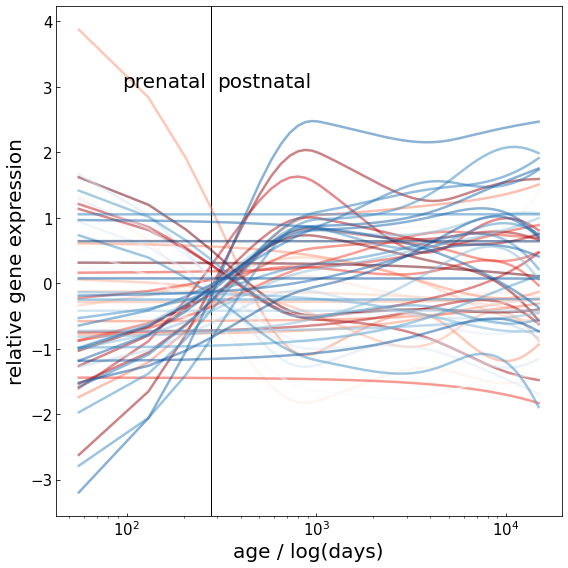

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (8,8), sharey=True)

sns.lineplot(x='age', y='fit', hue='PC', data=positive_trajectories, ax=ax, legend=False, palette='Reds', alpha=0.5, lw=2.5)
sns.lineplot(x='age', y='fit', hue='PC', data=negative_trajectories, ax=ax, legend=False, palette='Blues', alpha=0.5, lw=2.5)


ax.axvline(280, c='black', lw=1, zorder=0)
ax.set_xscale('log')
ax.text(300, 3, 'postnatal', fontsize=20)
ax.text(95, 3, 'prenatal', fontsize=20)
ax.tick_params('both', labelsize=15, direction='in')
ax.set_xlabel('age / log(days)', fontsize=20)
ax.set_ylabel('relative gene expression', fontsize=20)
plt.tight_layout()

### As above, by different cell types

In [24]:
# load mouse cell genes list
# load Ensembl human-mouse genes
all_homologs = pd.read_csv('data/gene_data/gene_lists/mart_export.txt', delimiter='\t')
neuron_lists = pd.read_csv('data/gene_data/gene_lists/TH_Neuron_ALL.csv')['gene']
glial_lists = pd.concat((pd.read_csv('data/gene_data/gene_lists/TH_Astrocyte_Gja1.csv'), 
                         pd.read_csv('data/gene_data/gene_lists/TH_Oligodendrocyte_ALL.csv'), 
                         pd.read_csv('data/gene_data/gene_lists/TH_Ependyma.csv')))['gene'].unique()

# get human homologs
neuron_homologs = all_homologs[all_homologs['Mouse gene name'].isin(list(neuron_lists))]['Gene name'].dropna()
glial_homologs = all_homologs[all_homologs['Mouse gene name'].isin(list(glial_lists))]['Gene name'].dropna()

# select trajectories
positive_neuron_traj = positive_trajectories[positive_trajectories.symbol.isin(neuron_homologs.values)]
negative_neuron_traj = negative_trajectories[negative_trajectories.symbol.isin(neuron_homologs.values)]
positive_glial_traj = positive_trajectories[positive_trajectories.symbol.isin(glial_homologs.values)]
negative_glial_traj = negative_trajectories[negative_trajectories.symbol.isin(glial_homologs.values)]

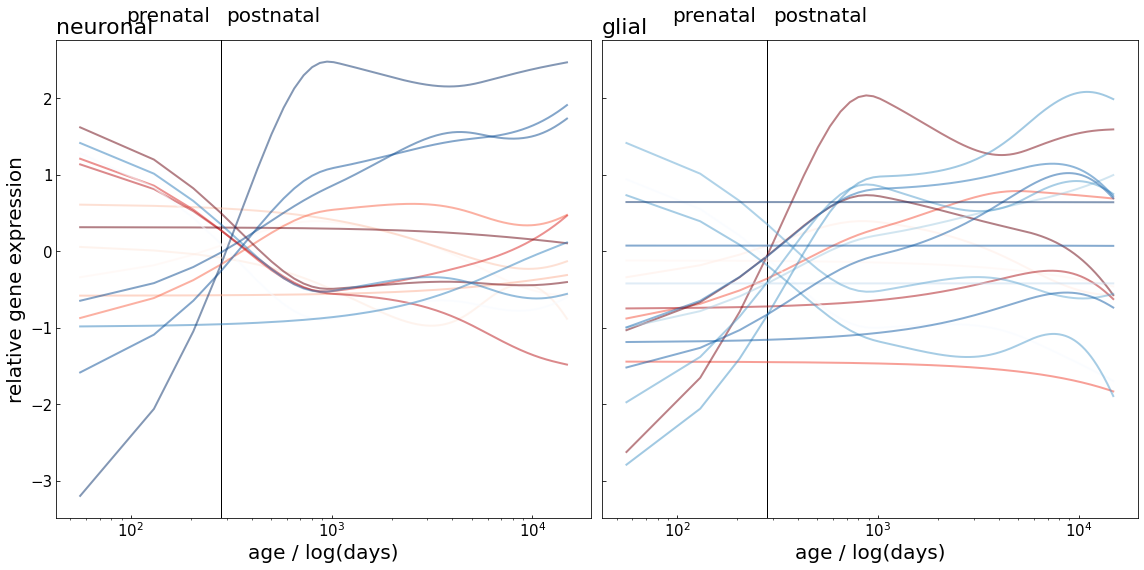

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (16,8), sharey=True)

sns.lineplot(x='age', y='fit', hue='PC', data=positive_neuron_traj, ax=ax[0], legend=False, palette='Reds', alpha=0.5, lw=2)
sns.lineplot(x='age', y='fit', hue='PC', data=negative_neuron_traj, ax=ax[0], legend=False, palette='Blues', alpha=0.5, lw=2)

sns.lineplot(x='age', y='fit', hue='PC', data=positive_glial_traj, ax=ax[1], legend=False, palette='Reds', alpha=0.5, lw=2)
sns.lineplot(x='age', y='fit', hue='PC', data=negative_glial_traj, ax=ax[1], legend=False, palette='Blues', alpha=0.5, lw=2)

for axes in ax:
    axes.axvline(280, c='black', lw=1, zorder=0)
    axes.set_xscale('log')
    axes.text(300, 3, 'postnatal', fontsize=20)
    axes.text(95, 3, 'prenatal', fontsize=20)
    axes.tick_params('both', labelsize=15, direction='in')
    axes.set_xlabel('age / log(days)', fontsize=20)
    axes.set_ylabel('relative gene expression', fontsize=20)

ax[0].set_title('neuronal', loc='left', fontsize=22)
ax[1].set_title('glial', loc='left', fontsize=22)

plt.tight_layout()

In [26]:
# Gene lists for supplemental
# DOWN over time and medially enriched
a = negative_trajectories.groupby(by=['symbol', 'window'])[['fit']].mean().reset_index()
b = a.groupby('symbol')['fit']
# pre vs post - negative values is higher in prenatal than postnatal
prepost = b.first().sub(b.last())
down_neg = list(set(negative_trajectories.symbol.unique()) & set(prepost[prepost<0].index))

# UP over time and medially enriched
up_neg = list(set(negative_trajectories.symbol.unique()) & set(prepost[prepost>0].index))

# DOWN over time and medially enriched
a = positive_trajectories.groupby(by=['symbol', 'window'])[['fit']].mean().reset_index()
b = a.groupby('symbol')['fit']
# pre vs post - negative values is higher in prenatal than postnatal
prepost = b.first().sub(b.last())
down_pos = list(set(positive_trajectories.symbol.unique()) & set(prepost[prepost<0].index))

# UP over time and medially enriched
up_pos = list(set(positive_trajectories.symbol.unique()) & set(prepost[prepost>0].index))

In [27]:
# Genes that are medially and prenatally enriched
print(down_neg)

['RASGEF1C', 'KLHDC8A', 'POU3F3', 'KIAA1549', 'FAM181B', 'SOX1', 'GRM3', 'PHF21B', 'RAB33A', 'TUBB3']


Of note: [EFNB3](https://www.genecards.org/cgi-bin/carddisp.pl?gene=EFNB3) has important role in forebrain development. DLX1 is a marker of thalamic interneurons generated from ganglionic eminence that populate [higher order thalamus](https://pubmed.ncbi.nlm.nih.gov/11528425/) and is reduced in [SCZ and BPD](https://jamanetwork.com/journals/jamapsychiatry/fullarticle/207785). GLRA2 promotes [interneuron migration](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3763372/). CNR1 is an GABAergic interneuron marker. LYH6 is expressed in primate [medial dorsal nucleus](https://onlinelibrary.wiley.com/doi/10.1002/cne.25203)

In [28]:
# Genes that are medially and posnatally enriched
print(up_neg)

['GREM1', 'RCAN2', 'FAM131C', 'PRUNE2', 'CNTN3', 'CHN1', 'SYNGR3', 'DKK3', 'MAP6D1', 'CAP2', 'PRNP', 'PDE8B', 'PCDH10', 'KLHL4', 'BEST1', 'SLC10A4', 'ABLIM2', 'SORCS1', 'ATP10B', 'ENTPD2', 'PCDH9']


ZCCHC12 expressed in [MGE-derived interneurons](https://www.frontiersin.org/articles/10.3389/fnmol.2021.712609) as is [ALK](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4571608/). GABRG1,3 are GABA receptor subunits. 

In [29]:
# Genes that are laterally and prenatally enriched
print(down_pos)

['LRFN1', 'CSPG5', 'DCLK2', 'SEZ6', 'INSM1', 'L1CAM', 'IGFBPL1', 'ST6GAL2', 'GPM6A', 'ADCYAP1R1', 'NOL4']


DSCAML1 involved in [thalamocortical outgrowth](https://www.frontiersin.org/articles/10.3389/fcell.2020.624181/full). Disruption of thalamic expression of ADCY1 leads to [severe cortical patterning errors and somatosensory disruption](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4596139/)


In [30]:
# Genes that are laterally and postnatally enriched
print(up_pos)

['DOC2A', 'LRFN5', 'HAP1', 'SLC13A5', 'PLCH1', 'PCP4L1', 'MC4R', 'SYT16', 'SCARA3', 'SUSD5', 'UNC13C', 'PTCHD1', 'CCKBR', 'GLRA3', 'SYT12', 'LHFPL1']


Neurons! Largely excitatory as per the cell enrichment results. I think together shows that the spatial gradient reflects both differentail inhib/excit cell ratios in the adult thalamus as well as reflecting early organisational patterning in the thalamus formed from interneruon migration from medial forebrain and neurogenesis in lateral->medial

In [31]:
genelist=pd.DataFrame({'Negative_prenatal' : pd.Series(down_neg), 'Negative_postnatal' : pd.Series(up_neg), 'Positive_prenatal' : pd.Series(down_pos), 'Positive_postnatal' : pd.Series(up_pos)})
genelist.to_csv('data/processed/SigDevelopmentalTrajectoryGenes_' + OUTNAME +'.csv', index=False)
